# Loan Data from Prosper Exploration
## by Jeff Mitchell

## Preliminary Wrangling

This dataset contains information on nearly 114,000 loans from Prosper. The dataset contains a lot of features and will require some wrangling before we can start analysing it.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [2]:
loans = pd.read_csv('prosperLoanData.csv')

In [3]:
# high-level overview of data shape and composition
print(loans.shape)
print(loans.dtypes)

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


### What is the structure of your dataset?

There are 113,937 loans with 81 features for each loan. This is a lot of features and some are only relevant to certain periods of time (e.g. pre-2009, post-July 2009). These features include details such as Term, Loan status, Borrower rate, various scores and ratings, demographic features such as Occupation, Employment status, Home ownership, various credit scores and totals, income range and details specific to the loan.

### What is/are the main feature(s) of interest in your dataset?

I am most interested in finding out what features have the greatest impact on Loan Outcome Status, specifically on whether or not the loan is paid off.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

There are a number of features that I feel to be of interest in investigating Loan Outcome Status. These include the reason for the loan (ListingCategory), their employment status (EmploymentStatus), their home ownership status, their credit scores, number of delinquincies, their debt-to-income ratio (DebtToIncomeRatio), their monthly income, the amount of the loan (LoanOriginalAmount) and level of monthly payments (MonthlyLoanPayment). I expect that borrowers with higher debt-to-income ratios, lower monthly income and lower credit scores are less likely to complete their loan payments.

### Initial cleaning

A quick visual assessment looking at the data file shows that the data requires some initial cleaning before I can start analysing it. This will involve dropping unnecessary columns, cleaning column types and creating new columns to help with the analysis.

There are a lot of columns in the data which makes useful analysis difficult. I will start by reducing the dataframe to only the columns that are of interest to me for investigating the Loan Status Outcome. For example, LoanNumber can be used to identify individual loans. This removes the need to hold ListingNumber, ListingKey and LoanKey which are all associated with a unique LoanNumber.

In [4]:
# Reduce the number of columns to just those that may be of interest
columns = ['Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'ListingCategory (numeric)', 'EmploymentStatus', 
           'IsBorrowerHomeowner', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'TotalCreditLinespast7years',
           'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 
           'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanNumber', 'LoanOriginalAmount', 'LoanOriginationQuarter',
           'MemberKey', 'MonthlyLoanPayment']
loans = loans[columns]

Some of the column headings are confusing or difficult to work with so I will rename them.

In [5]:
loans = loans.rename(columns={'ListingCategory (numeric)':'ListingCategory','IsBorrowerHomeowner':'HomeOwner',
                              'TotalCreditLinespast7years':'TotalCreditLines',
                              'DelinquenciesLast7Years':'TotalDelinquencies'})

I am interested in the effect of the features on Loan Outcome Status. Loans that have not yet reached an outcome need to be removed as I do not know what their final outcome will be (I cannot identify what effect their features have on Loan Outcome Status as their status is not yet known). First I will check the values in the LoanStatus column.

In [6]:
loans.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

For this analysis I am going to consider 'Chargedoff' and 'Defaulted' as loans that were not completed successfully. Loans that are 'Past Due...' I will consider current.The loans to be removed are those listed as 'Current', 'Past Due...' and 'FinalPaymentInProgress'. 

In [7]:
# Remove loans that have not reached an outcome
loans = loans[loans['LoanStatus'].isin(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'])]
loans.LoanStatus.value_counts()

Completed     38074
Chargedoff    11992
Defaulted      5018
Cancelled         5
Name: LoanStatus, dtype: int64

I am interested in knowing the outcome of the loan - if it was successfully paid off or not. This will be easiest by creating a new column that records the final status of the loan - LoanCompleted - which holds a string, either 'Completed' (paid off) or 'Not completed' (not paid off).

In [8]:
# Return loan completion status
def getLoanCompleted(loan_status):
    """Return True if loan completed, False otherwise."""
    if loan_status.strip() == 'Completed':
        return 'Completed'
    else:
        return 'Not completed'
    
# Create column to hold status of loan outcome
loans['LoanCompleted'] = loans['LoanStatus'].apply(getLoanCompleted)

# Drop LoanStatus column
loans.drop('LoanStatus', axis=1, inplace=True)

In [9]:
# Examine remaining columns
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55089 entries, 0 to 113935
Data columns (total 21 columns):
Term                           55089 non-null int64
BorrowerAPR                    55064 non-null float64
BorrowerRate                   55089 non-null float64
ListingCategory                55089 non-null int64
EmploymentStatus               52834 non-null object
HomeOwner                      55089 non-null bool
CreditScoreRangeLower          54498 non-null float64
CreditScoreRangeUpper          54498 non-null float64
TotalCreditLines               54392 non-null float64
OpenRevolvingAccounts          55089 non-null int64
OpenRevolvingMonthlyPayment    55089 non-null float64
CurrentDelinquencies           54392 non-null float64
TotalDelinquencies             54099 non-null float64
DebtToIncomeRatio              50859 non-null float64
StatedMonthlyIncome            55089 non-null float64
LoanNumber                     55089 non-null int64
LoanOriginalAmount             55089 n

Several of the columns will need some cleaning before we can perform analysis on them.

In [10]:
# Convert LoanNumber to a string as we will not perform calcluations on it
loans['LoanNumber'] = loans['LoanNumber'].astype('str')

The Listing Category column currently only has ints. These will be much easier to analyse by converting them to a string that states what the int represents and then setting the column to category type.

In [11]:
# Convert the ListingCategory column to readable values
def convert_listing_category(cat):
    """Convert the listing category to a human-readable string."""
    categories = ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use',
                 'Auto', 'Other', 'Baby and Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans',
                 'Household Expense', 'Large Purchases', 'Medical and Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
                 'Wedding']
    return categories[cat]

loans['ListingCategory'] = loans['ListingCategory'].apply(convert_listing_category)

In [12]:
# Convert ListingCategoy to categorical types
loans['ListingCategory'] = loans['ListingCategory'].astype('category')

The null values in EmploymentStatus can also be represented by the existing 'Not available' value, so these should be converted to be consistent and make analysis easier. The column can then be changed to a category type.

In [13]:
# Convert null EmploymentStatus to 'Not Available'
loans['EmploymentStatus'] = loans['EmploymentStatus'].fillna('Not available')

In [14]:
# Convert EmploymentStatus to categorical type
loans['EmploymentStatus'] = loans['EmploymentStatus'].astype('category')

LoanOriginationQuarter can also be converted to a category type.

In [15]:
# Convert LoanOriginationQuarter to categorical type
loans['LoanOriginationQuarter'] = loans['LoanOriginationQuarter'].astype('category')

In [16]:
loans.Term.value_counts()

36    49861
60     3696
12     1532
Name: Term, dtype: int64

There are only three possible terms, so these are better represented as categories

In [17]:
# Convert Term to categorical type
loans['Term'] = loans['Term'].astype('category')

The Credit Score will be more useful if there is one Credit Score value per row, rather than a lower and upper value. A new column can be created that holds the mean of the lower and upper scores for each row.

In [18]:
# Function to calculate mean of lower and upper credit ratings
def get_rating(lower, upper):
    "Calculate mean of lower and upper credit ratings."
    mean = (lower + upper) / 2
    return mean

# Add CreditScore column and populate
loans['CreditScore'] = loans.apply(lambda x: get_rating(x['CreditScoreRangeLower'], x['CreditScoreRangeUpper']), axis=1)

# Drop unneeded Credit Range columns
loans.drop(['CreditScoreRangeLower','CreditScoreRangeUpper'], axis=1, inplace=True)

As I will be using LoanNumber to identify unique loans, I need to make sure there are no duplicated loan records.

In [19]:
dupes = loans[loans['LoanNumber'].duplicated() == True]
dupes

,Term,BorrowerAPR,BorrowerRate,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
33959,60,0.28875,0.2624,Business,Employed,False,61.0,7,255.0,0.0,0.0,0.33,4506.666667,131358,5500,Q1 2014,85D535659273197054A0BB3,165.45,Completed,669.5
37956,36,0.22875,0.1915,Debt Consolidation,Employed,False,19.0,13,459.0,0.0,0.0,0.20,6083.333333,105288,20000,Q4 2013,8EC335867884136891E9E14,734.64,Completed,669.5
51079,36,0.23438,0.1970,Debt Consolidation,Employed,True,43.0,13,1027.0,0.0,0.0,0.16,14583.333333,123094,5000,Q4 2013,9FA83698836314377793393,185.05,Completed,669.5
60004,36,0.13799,0.1099,Other,Employed,True,21.0,6,237.0,0.0,1.0,0.23,4250.000000,110303,2000,Q4 2013,4553358888719707373CD1C,65.47,Completed,689.5
61289,36,0.09000,0.0766,Debt Consolidation,Self-employed,True,17.0,5,178.0,0.0,0.0,NaN,7500.000000,107275,3500,Q4 2013,34193560492599576667729,109.13,Completed,809.5
68585,36,0.18633,0.1500,Debt Consolidation,Employed,False,40.0,16,604.0,0.0,0.0,0.34,7500.000000,121979,15000,Q4 2013,27FA3533700778342A3BB33,519.98,Completed,709.5
70435,60,0.19988,0.1760,Debt Consolidation,Employed,True,26.0,8,159.0,2.0,0.0,0.26,4125.000000,119188,15000,Q4 2013,4FC835464074587007C7ABC,377.64,Completed,729.5
96475,60,0.22601,0.2015,Debt Consolidation,Employed,False,20.0,11,506.0,0.0,0.0,0.23,4125.000000,101908,15000,Q3 2013,7EF83383685864632D111F0,398.66,Completed,689.5
97137,36,0.32446,0.2850,Debt Consolidation,Employed,False,30.0,6,88.0,0.0,13.0,0.17,5833.333333,121751,4000,Q4 2013,4E9335537538907782E9392,166.54,Completed,669.5
97330,60,0.23318,0.2085,Debt Consolidation,Employed,True,26.0,8,339.0,0.0,0.0,0.32,4166.666667,118909,13000,Q4 2013,117636957815160767DC8DC,350.60,Completed,689.5


There are 13 duplicated records in the data based on LoanNumber. A visual check of these in the raw data showed that the only difference between the duplicates was the ProsperScore, which is not being used in this analysis. For this reason we can drop the duplicate values.

In [20]:
# Drop rows duplicated on LoanNumber
loans.drop_duplicates('LoanNumber', inplace=True)

In [21]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55076 entries, 0 to 113935
Data columns (total 20 columns):
Term                           55076 non-null category
BorrowerAPR                    55051 non-null float64
BorrowerRate                   55076 non-null float64
ListingCategory                55076 non-null category
EmploymentStatus               55076 non-null category
HomeOwner                      55076 non-null bool
TotalCreditLines               54379 non-null float64
OpenRevolvingAccounts          55076 non-null int64
OpenRevolvingMonthlyPayment    55076 non-null float64
CurrentDelinquencies           54379 non-null float64
TotalDelinquencies             54086 non-null float64
DebtToIncomeRatio              50847 non-null float64
StatedMonthlyIncome            55076 non-null float64
LoanNumber                     55076 non-null object
LoanOriginalAmount             55076 non-null int64
LoanOriginationQuarter         55076 non-null category
MemberKey                     

### Missing Values

There are several columns that contain missing values. We need to address each of these individually.

There are 25 rows missing the BorrowerAPR. This is a very small percentage of the total so we can use the mean for the column to fill these values.

In [22]:
# Fill missing BorrowerAPR values with the mean for the columnm
mean_apr = loans.BorrowerAPR.mean()
loans['BorrowerAPR'] = loans.BorrowerAPR.fillna(mean_apr)

There are 591 rows missing Credit Score details. We should check what other information these rows are missing.

In [23]:
missing = loans[loans['CreditScore'].isnull() == True]
missing.head()

,Term,BorrowerAPR,BorrowerRate,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
206,36,0.27767,0.2700,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.16573,9166.666667,323,7500,Q1 2006,110A336465998424756030B,306.19,Not completed,NaN
387,36,0.09337,0.0865,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.12624,3000.000000,174,3500,Q1 2006,69D933646754525905A852D,110.73,Completed,NaN
698,36,0.07680,0.0700,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.02727,8333.333333,36,6001,Q1 2006,8DE133657363264326FD856,185.29,Completed,NaN
1023,36,0.08684,0.0800,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.02480,8333.333333,396,5000,Q2 2006,6D11336601070734709170C,156.68,Completed,NaN
1126,36,0.20735,0.2000,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.13759,4250.000000,202,2550,Q1 2006,EDAD3365722336384C605F7,94.77,Completed,NaN


We can see that these rows are missing all of their credit data along with Listing Category, Employment Status, Delinquincies etc. We can drop these rows from the data as they only represent around 1% of the target data and I do not want to introduce noise or errors by using the mean for these values.

In [24]:
# Drop rows missing credit values
loans = loans[loans['CreditScore'].isnull() == False]
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54485 entries, 0 to 113935
Data columns (total 20 columns):
Term                           54485 non-null category
BorrowerAPR                    54485 non-null float64
BorrowerRate                   54485 non-null float64
ListingCategory                54485 non-null category
EmploymentStatus               54485 non-null category
HomeOwner                      54485 non-null bool
TotalCreditLines               54379 non-null float64
OpenRevolvingAccounts          54485 non-null int64
OpenRevolvingMonthlyPayment    54485 non-null float64
CurrentDelinquencies           54379 non-null float64
TotalDelinquencies             54086 non-null float64
DebtToIncomeRatio              50262 non-null float64
StatedMonthlyIncome            54485 non-null float64
LoanNumber                     54485 non-null object
LoanOriginalAmount             54485 non-null int64
LoanOriginationQuarter         54485 non-null category
MemberKey                     

The remaining columns that have missing values can be dealt with when they are analysed - the null values can remain in place. Now we can look at an overview of the remaining data of interest

In [25]:
print(loans.shape)
print(loans.dtypes)
print(loans.head())

(54485, 20)
Term                           category
BorrowerAPR                     float64
BorrowerRate                    float64
ListingCategory                category
EmploymentStatus               category
HomeOwner                          bool
TotalCreditLines                float64
OpenRevolvingAccounts             int64
OpenRevolvingMonthlyPayment     float64
CurrentDelinquencies            float64
TotalDelinquencies              float64
DebtToIncomeRatio               float64
StatedMonthlyIncome             float64
LoanNumber                       object
LoanOriginalAmount                int64
LoanOriginationQuarter         category
MemberKey                        object
MonthlyLoanPayment              float64
LoanCompleted                    object
CreditScore                     float64
dtype: object
   Term  BorrowerAPR  BorrowerRate    ListingCategory EmploymentStatus  \
0    36      0.16516        0.1580      Not Available    Self-employed   
2    36      0.28269      

In [26]:
loans.describe()

,BorrowerAPR,BorrowerRate,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanOriginalAmount,MonthlyLoanPayment,CreditScore
count,54485.000000,54485.000000,54379.000000,54485.000000,54485.000000,54379.000000,54086.000000,50262.000000,54485.000000,54485.000000,54485.000000,54485.000000
mean,0.222646,0.200789,25.274977,6.143104,328.796550,0.906563,4.572385,0.291532,5043.489058,6274.071983,224.260224,681.235340
std,0.088089,0.081165,14.268204,4.508924,450.006566,2.596514,10.690307,0.740366,5713.731383,5225.328950,186.029469,81.917545
min,0.006530,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,9.500000
25%,0.149900,0.135000,15.000000,3.000000,63.000000,0.000000,0.000000,0.130000,2804.166667,2600.000000,98.690000,649.500000
50%,0.214800,0.194900,23.000000,5.000000,186.000000,0.000000,0.000000,0.200000,4166.666667,4500.000000,172.760000,689.500000
75%,0.295250,0.269900,33.000000,8.000000,422.000000,1.000000,4.000000,0.300000,6250.000000,8000.000000,301.030000,729.500000
max,0.423950,0.360000,136.000000,51.000000,14985.000000,83.000000,99.000000,10.010000,618547.833333,35000.000000,2251.510000,889.500000


## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

I'll start by looking at the main variable of interest - the Loan Outcome Status

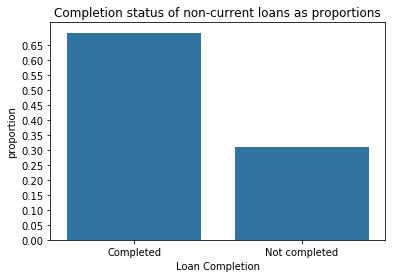

In [28]:
# Plot LoanCompleted column as %
base_color = sb.color_palette()[0]
n_points = loans.shape[0]
max_count = loans['LoanCompleted'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'LoanCompleted', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Loan Completion')
plt.title('Completion status of non-current loans as proportions');

We can see that close to 70% of the loans in the extracted data were completed and 30% were not completed (not paid off).

I'd like to check the distribution of some of the categorical variables next.

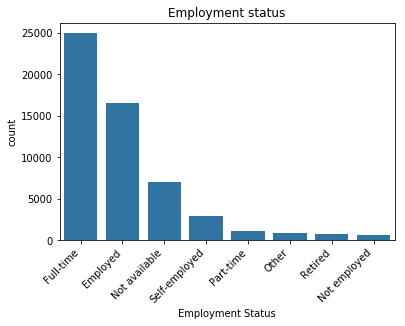

In [43]:
# Plot EmploymentStatus column
cat_order = loans['EmploymentStatus'].value_counts().index
sb.countplot(data = loans, x = 'EmploymentStatus', color = base_color, order=cat_order)
plt.xlabel('Employment Status')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Employment status');

We can see that most borrowers were involved in some form of employment, however, there was a large proportion that the employment status was unknown. The 'Employed' category is only of use if we group categories as either 'Employed' or 'Unemployed'. Given that most borrowers fall into the grouped Employed and Not available categories, we may not see much of an impact of employment status on the Loan Outcome Status. This is due to the relatively small sample size of unemployed categories.

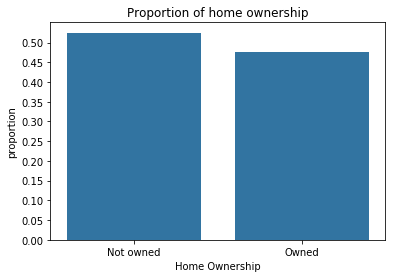

In [33]:
# Plot HomeOwnership column as %
n_points = loans.shape[0]
max_count = loans['HomeOwner'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'HomeOwner', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Home Ownership')
plt.xticks([0, 1], ['Not owned', 'Owned'])
plt.title('Proportion of home ownership');

Home ownership is split pretty evenly across the data.

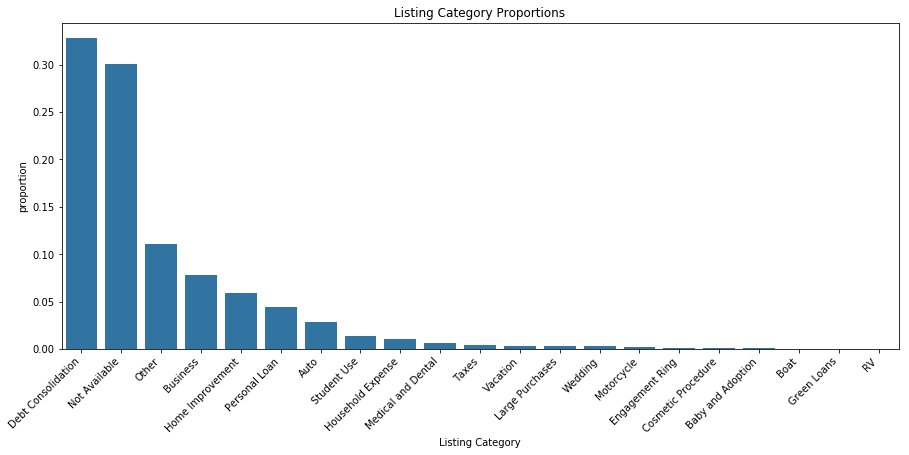

In [41]:
# Plot ListingCategory column as %
plt.figure(figsize=[15,6])
n_points = loans.shape[0]
cat_order = loans['ListingCategory'].value_counts().index
max_count = loans['ListingCategory'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'ListingCategory', color = base_color, order = cat_order)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Listing Category')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.title('Listing Category Proportions');

Over a third of the Listing Categories fall under 'Debt Consolidation'. Anothe third is 'Not Available' and a large number are also 'Other' which is not very helpful for analysis. These results suggest that Listing Category may not be a very useful feature use in our analysis.

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!